### Anomaly detection  
There are several methods including unsupervised (OneSVM, Isoletforest, LOF) and supervised. In this notebook, we illustrate how to use supervised Autoencoder.   

!pip install gdown    ## alternative wget to download from google drive    
!pip install tensorflow-gpu

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /Users/tridoan/spx.csv
100%|████████████████████████████████████████| 152k/152k [00:00<00:00, 2.48MB/s]


In [3]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [4]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


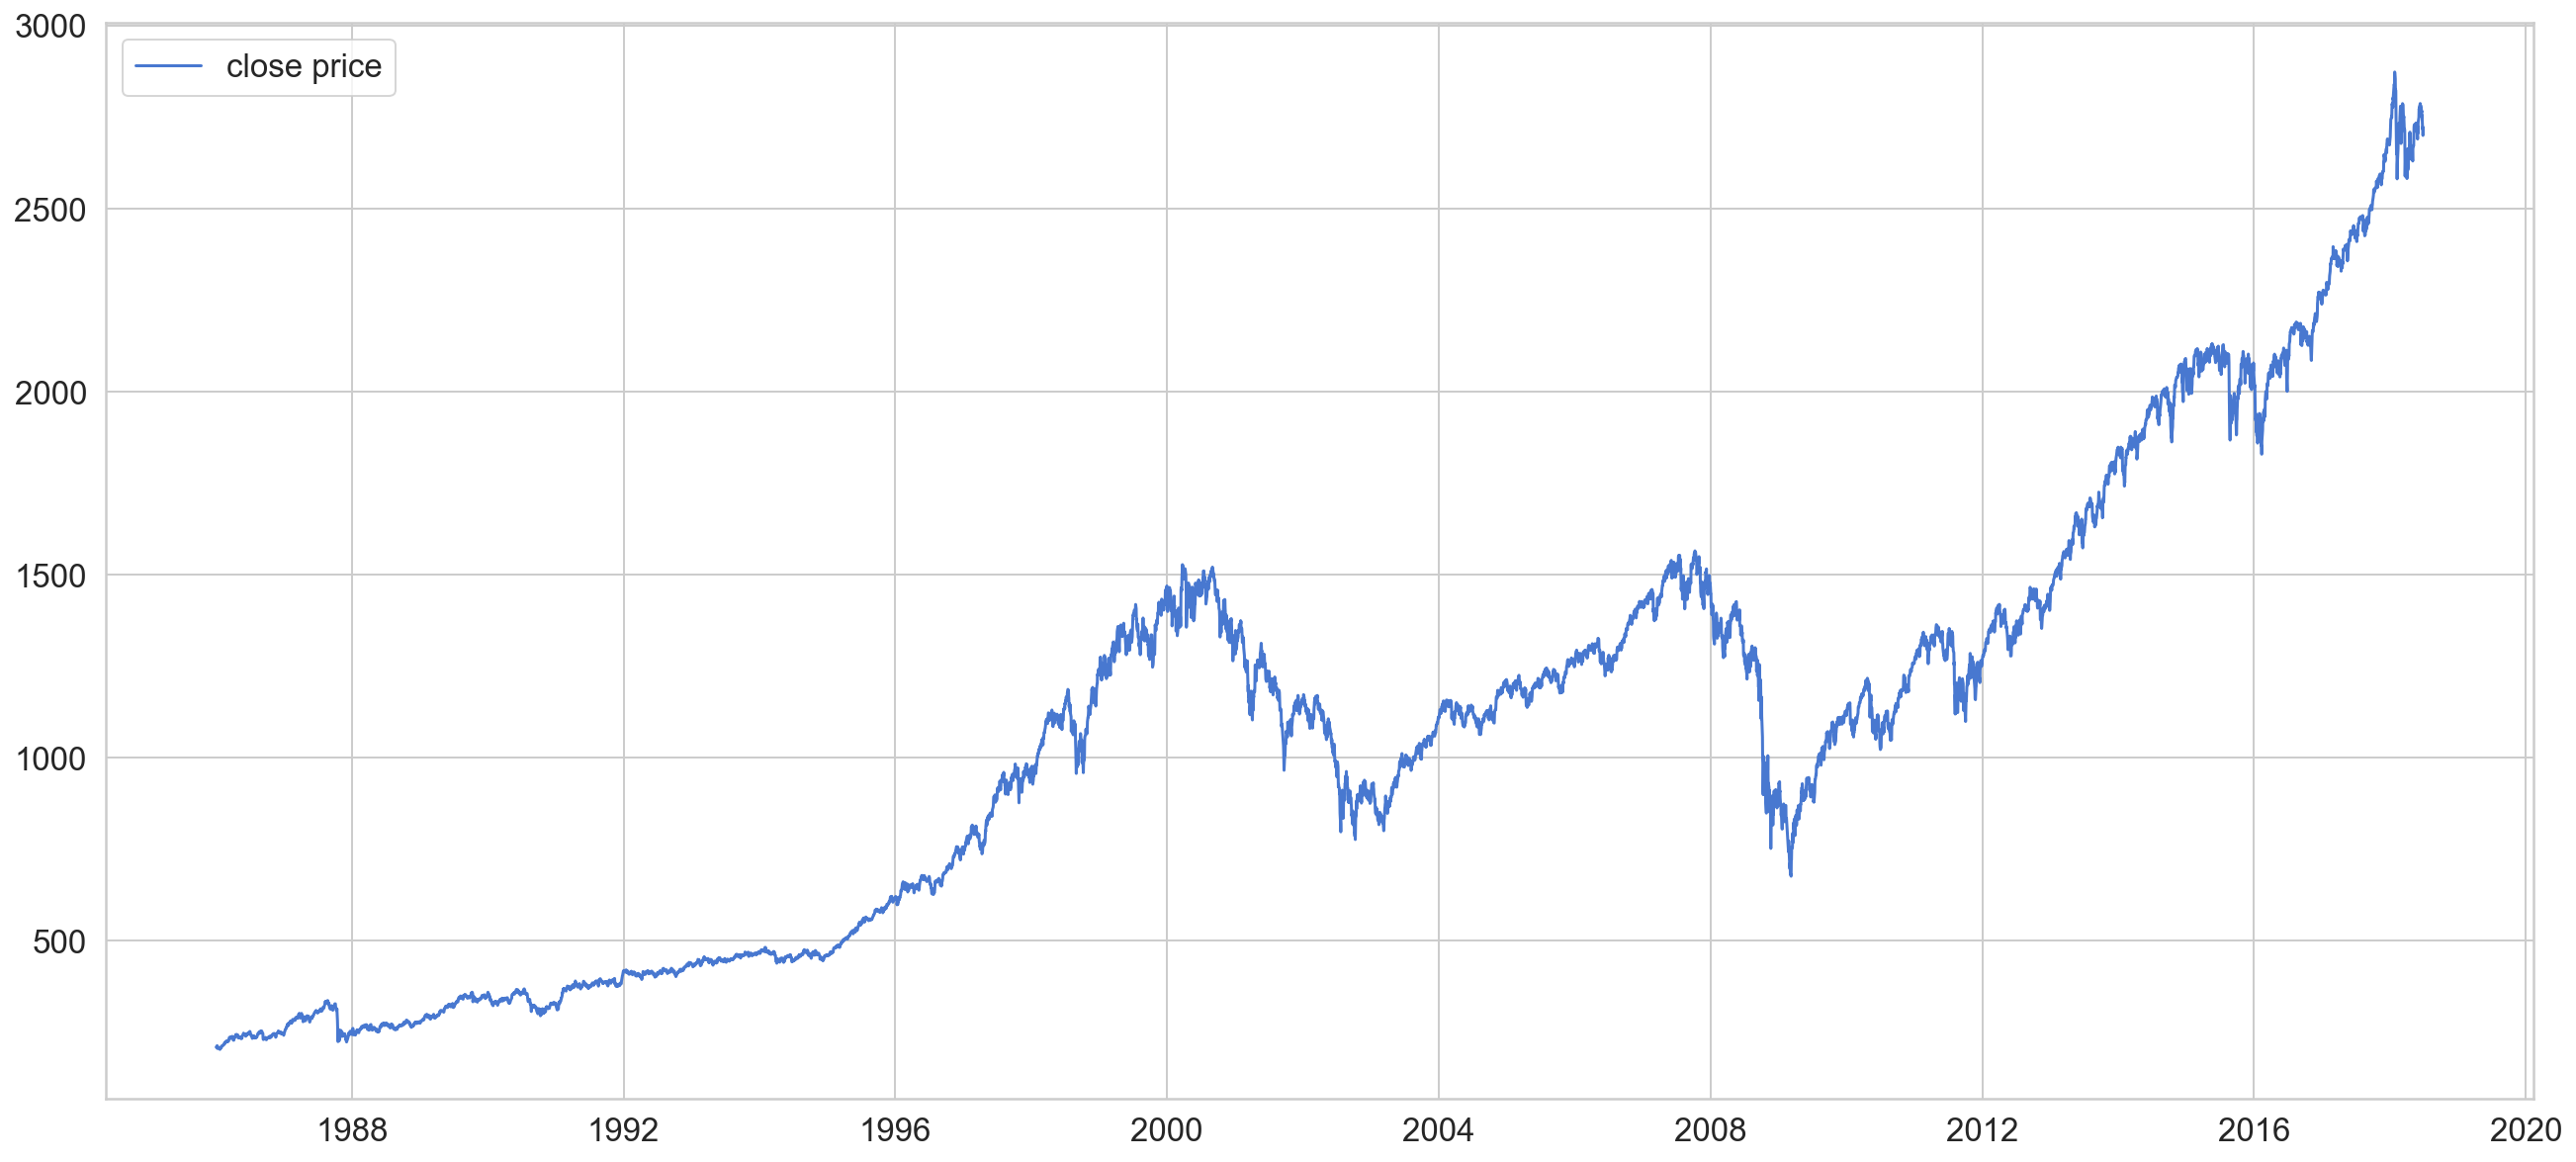

In [5]:
plt.plot(df, label='close price')
plt.legend();

In [13]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size].copy(), df.iloc[train_size:len(df)].copy()
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train.loc[:,['close']] = scaler.transform(train.loc[:,['close']])
test.loc[:,['close']] = scaler.transform(test.loc[:,['close']])

In [15]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [24]:
y_train

array([-1.46045696, -1.4560242 , -1.4509716 , ...,  2.14991562,
        2.19443107,  2.20235745])

### LSTM Autoencoder in Keras   

Our Autoencoder should take a sequence as input and outputs a sequence of the same shape. Here’s how to build such a simple model in Keras:

In [25]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

The RepeatVector layer simply repeats the input n times. Adding return_sequences=True in LSTM layer makes it return the sequence.

Finally, the TimeDistributed layer creates a vector with a length of the number of outputs from the previous layer. Your first LSTM Autoencoder is ready for training.

In [26]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 6976 samples, validate on 776 samples
Epoch 1/10
6976/6976 [==============================] - 8s 1ms/sample - loss: 0.1672 - val_loss: 0.1805
Epoch 2/10
6976/6976 [==============================] - 5s 780us/sample - loss: 0.0915 - val_loss: 0.2030
Epoch 3/10
6976/6976 [==============================] - 5s 700us/sample - loss: 0.0953 - val_loss: 0.1347
Epoch 4/10
6976/6976 [==============================] - 4s 619us/sample - loss: 0.0841 - val_loss: 0.1933
Epoch 5/10
6976/6976 [==============================] - 4s 623us/sample - loss: 0.0831 - val_loss: 0.1902
Epoch 6/10
6976/6976 [==============================] - 4s 643us/sample - loss: 0.0852 - val_loss: 0.2339
Epoch 7/10
6976/6976 [==============================] - 4s 629us/sample - loss: 0.0836 - val_loss: 0.1758
Epoch 8/10
6976/6976 [==============================] - 4s 626us/sample - loss: 0.0845 - val_loss: 0.1352
Epoch 9/10
6976/6976 [==============================] - 4s 610us/sample - loss: 0.0776 - val_loss: 0.1390
E

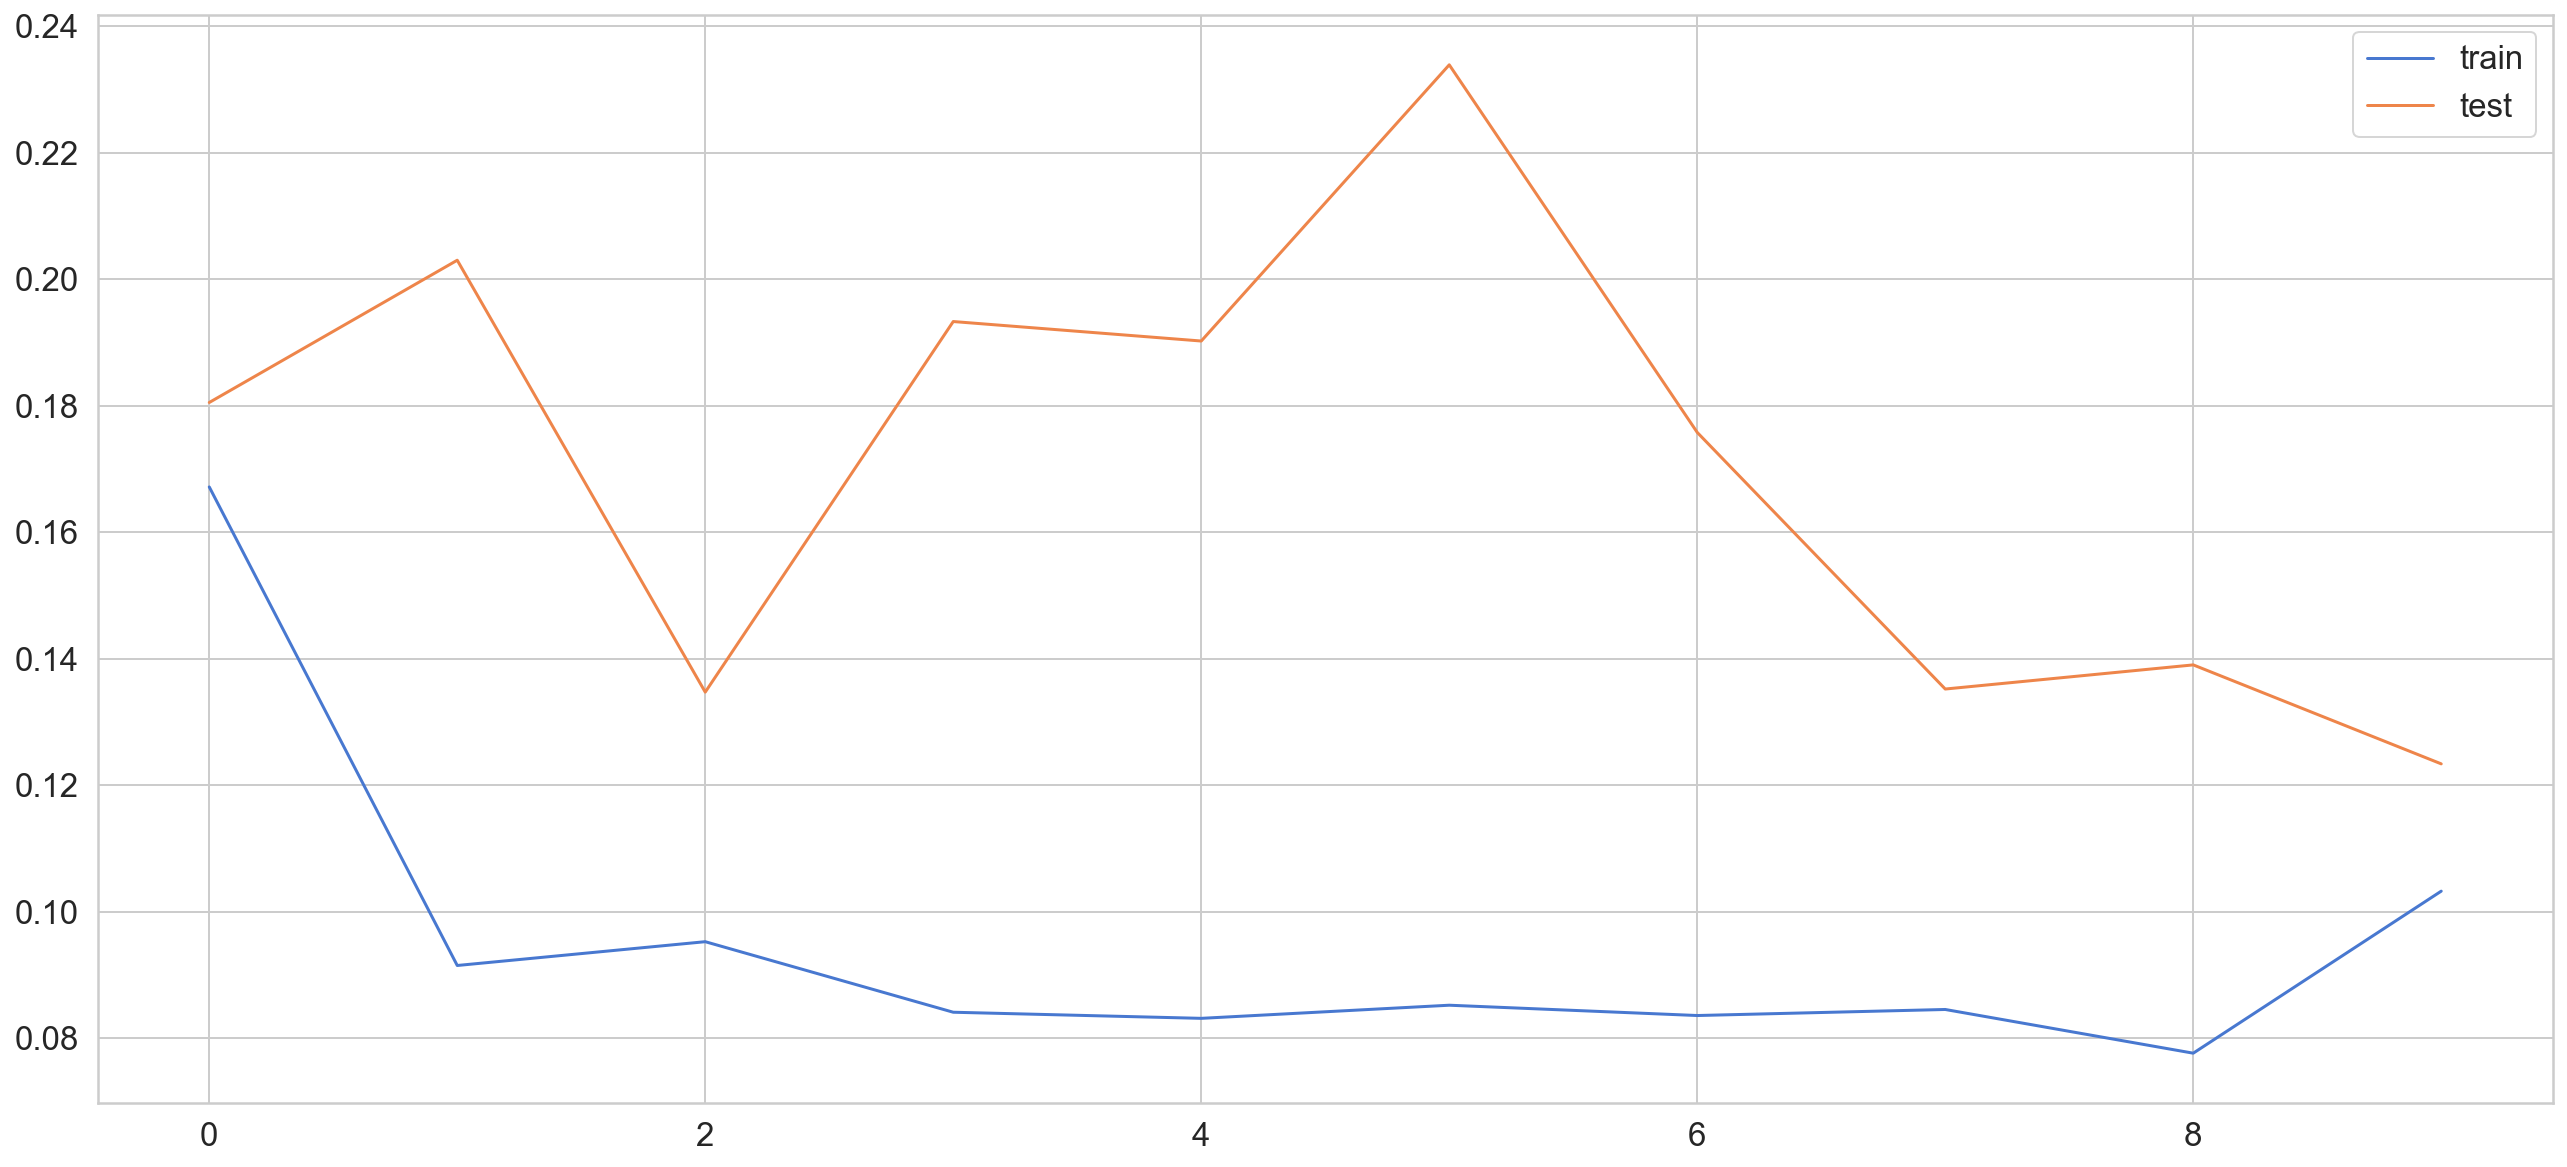

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Finding Anomalies

Still, we need to detect anomalies. Let’s start with calculating the Mean Absolute Error (MAE) on the training data:

In [28]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

### Let’s have a look at the error:

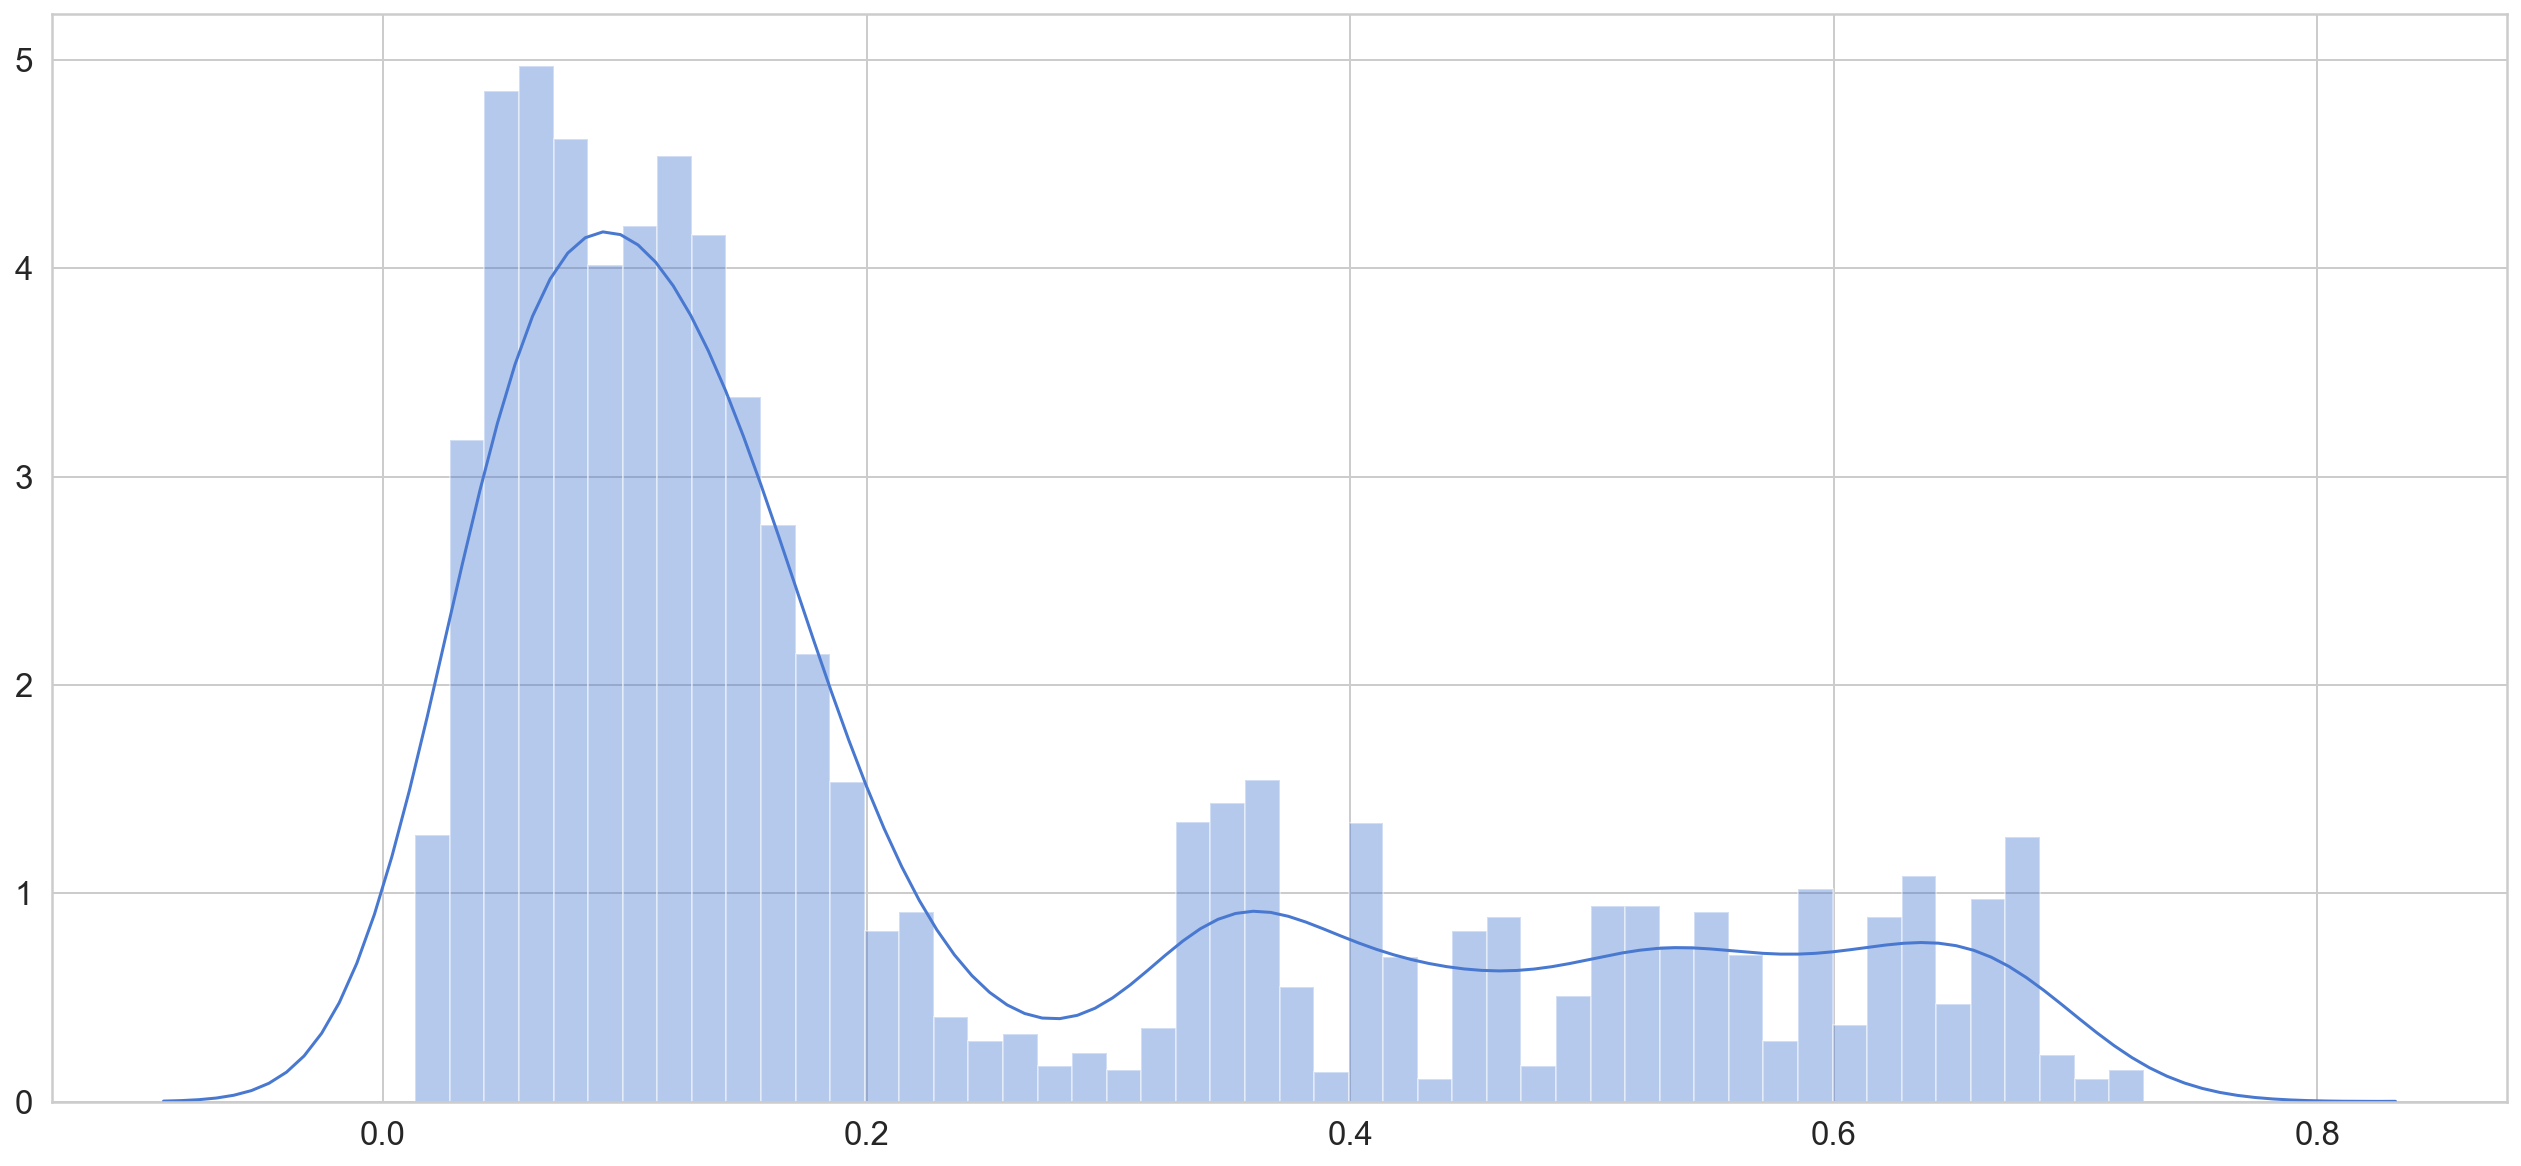

In [29]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [30]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

We’ll pick a threshold of 0.65, as not much of the loss is larger than that. When the error is larger than that, we’ll consider that example an anomaly:

We’ll build a DataFrame containing the loss and the anomalies (values above the threshold):

In [31]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

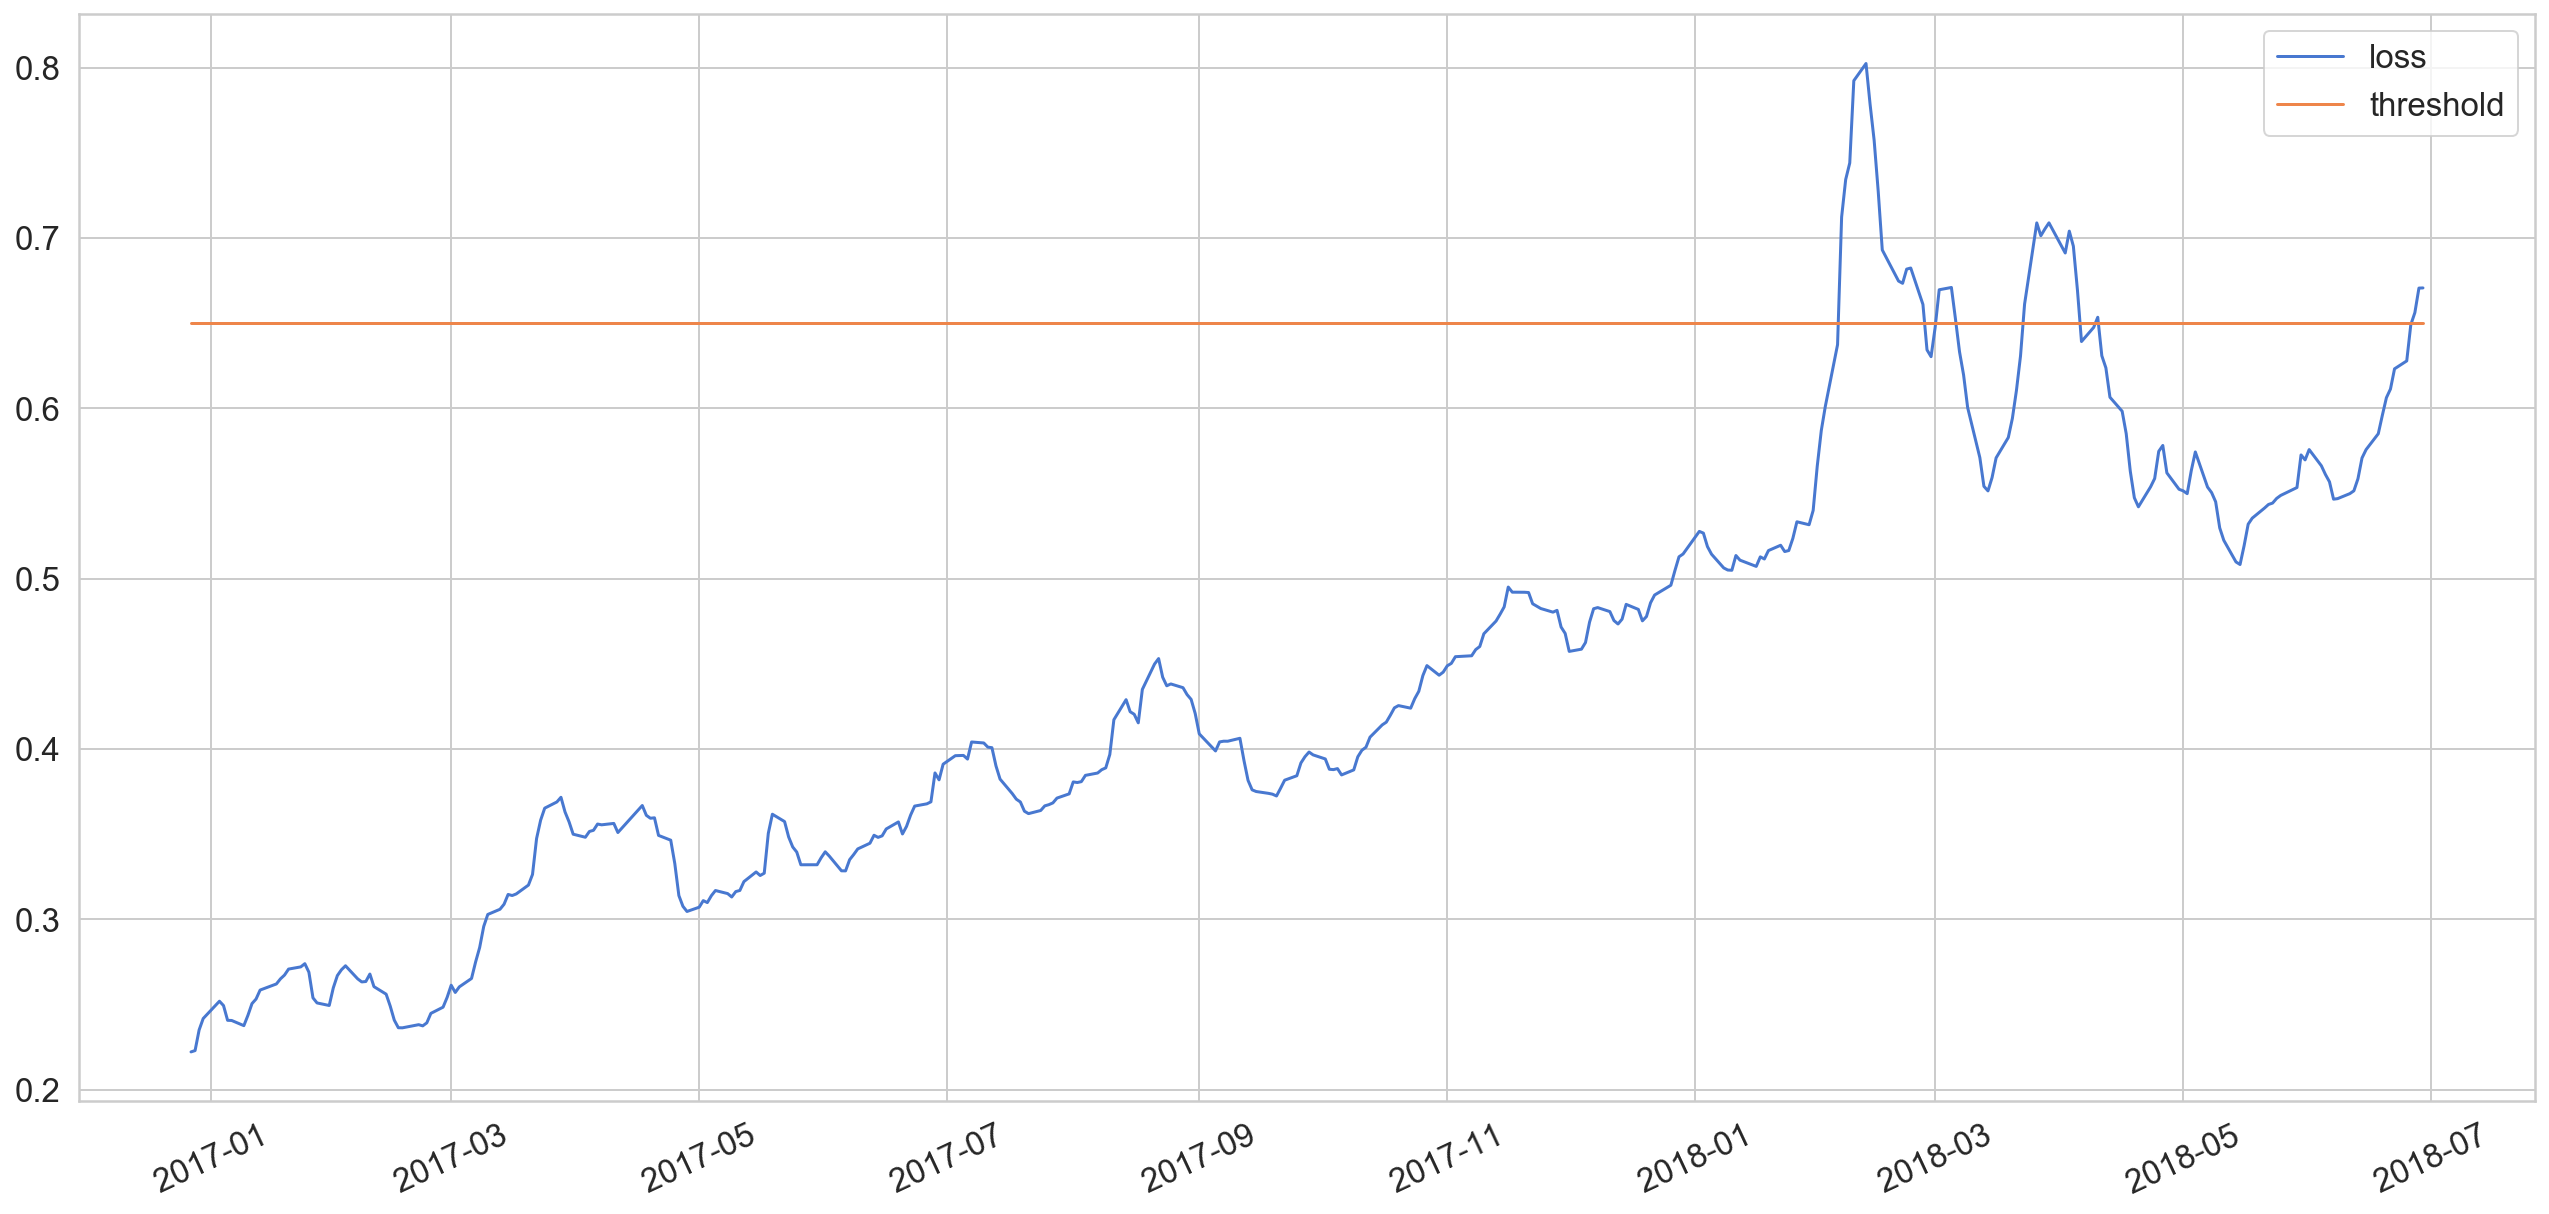

In [32]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

**Let’s create a DataFrame using only those:**

In [33]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.712378,0.65,True,3.193456
2018-02-07,0.734422,0.65,True,3.168136
2018-02-08,0.744130,0.65,True,2.979068
2018-02-09,0.792437,0.65,True,3.051476
2018-02-12,0.802513,0.65,True,3.119939


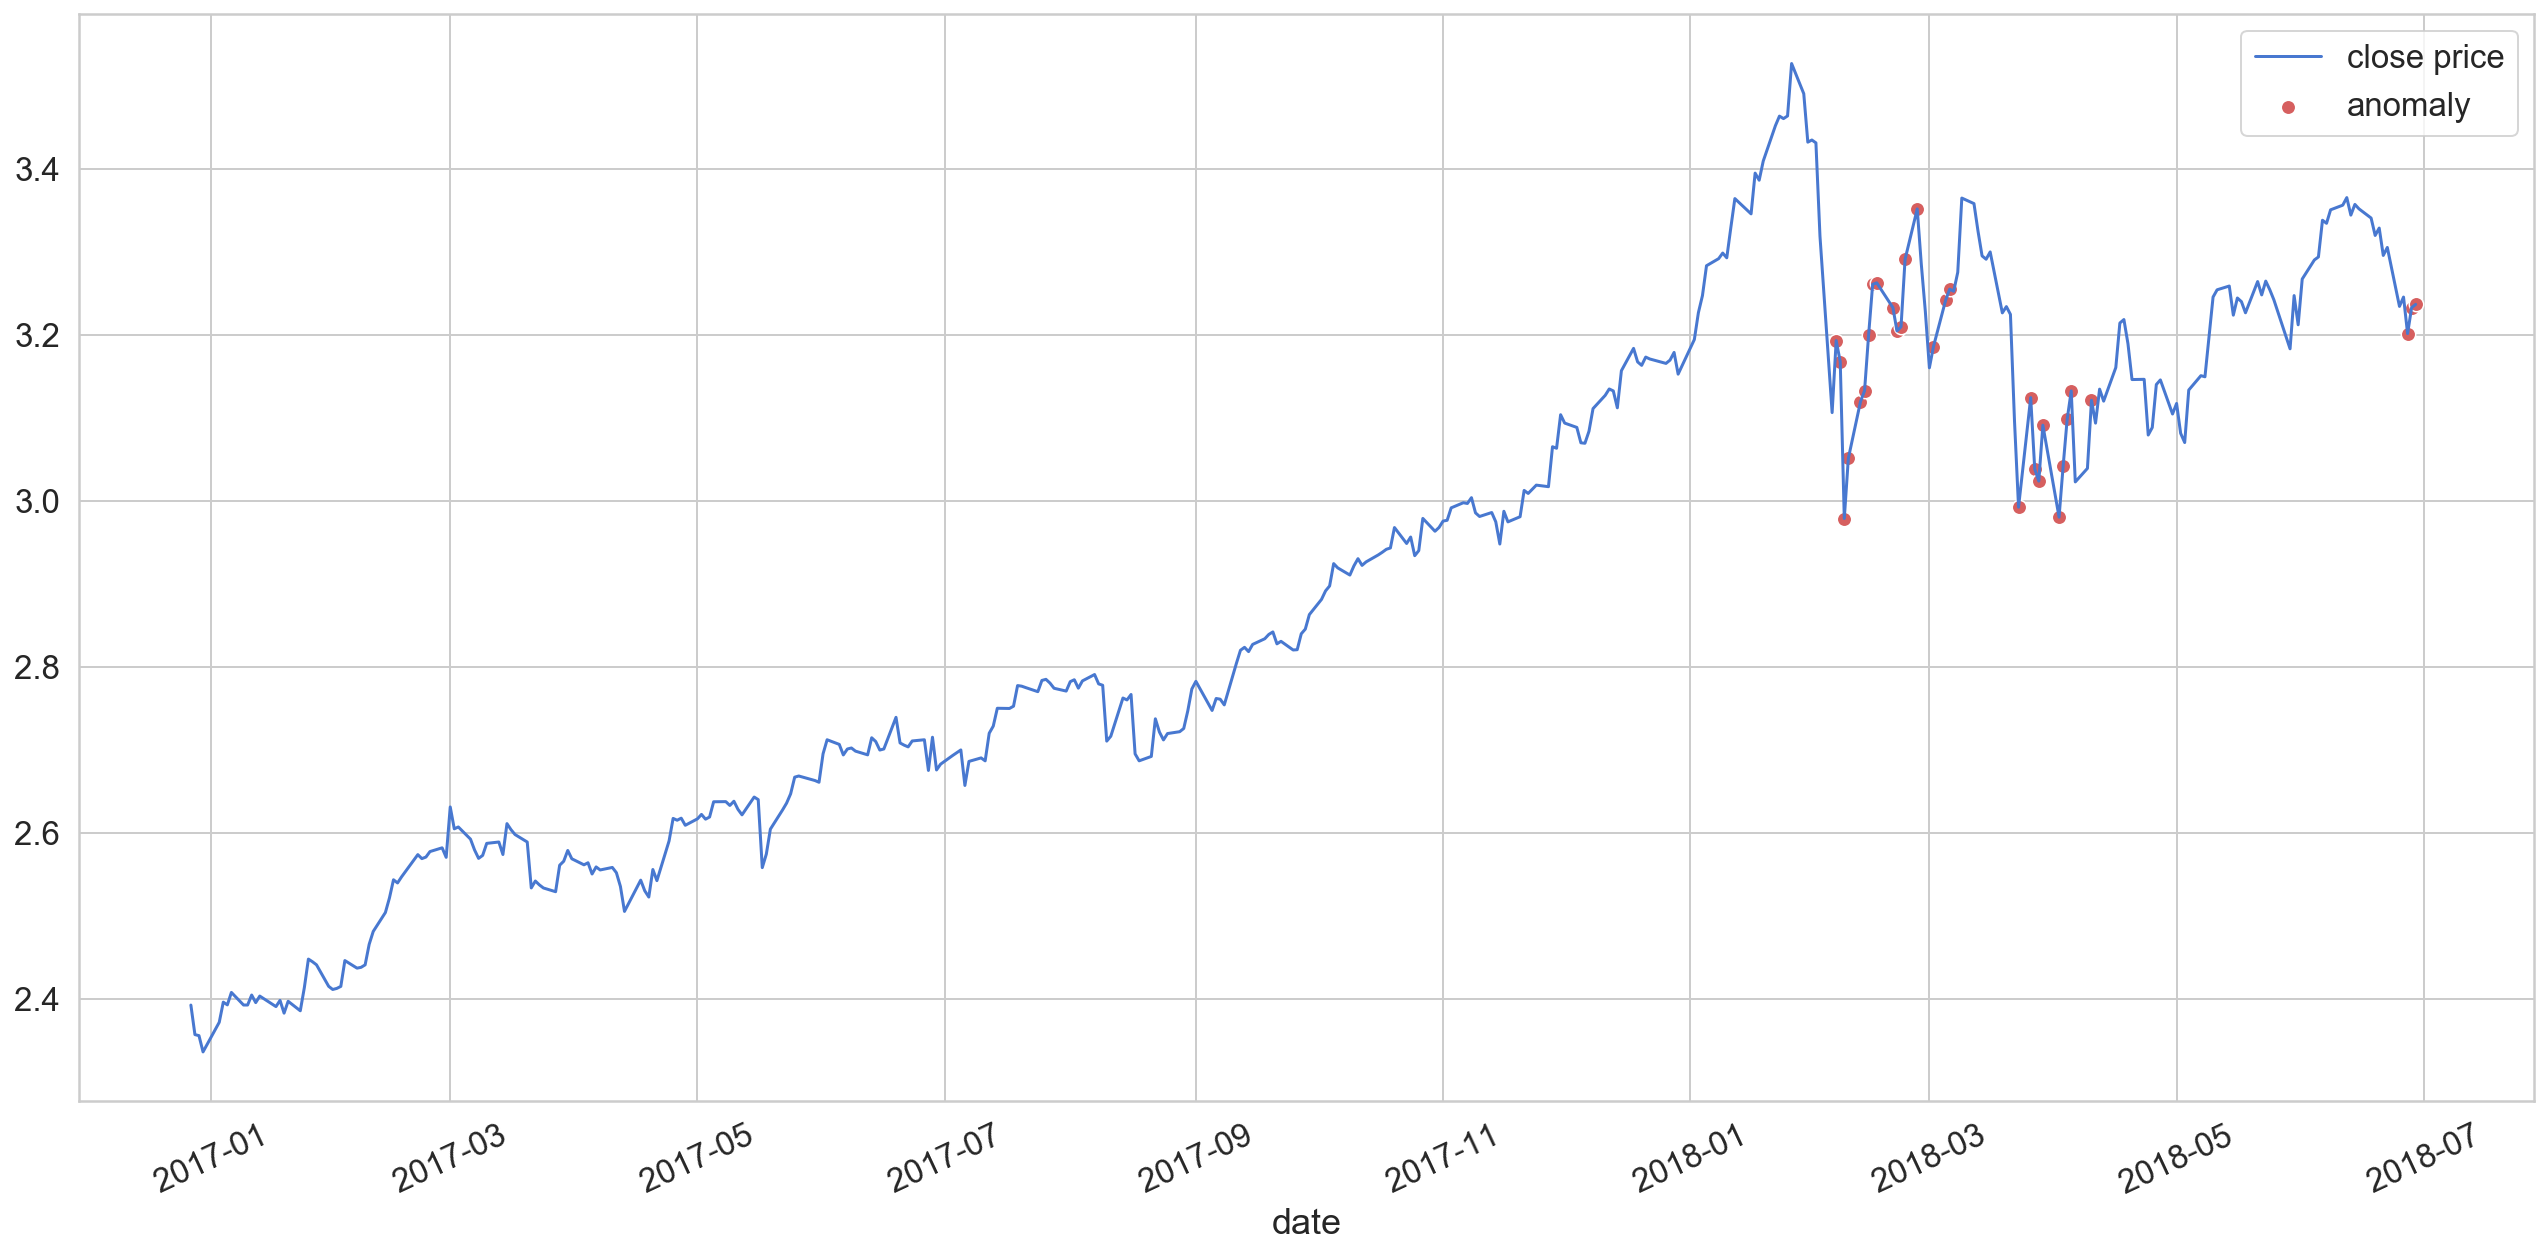

In [34]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

The red dots (anomalies) are covering most of the points with abrupt changes to the closing price